In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import mutual_info_regression

from sklearn.ensemble import RandomForestRegressor #, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [21]:
df_patients = pd.read_csv("data-p2/patients.csv")
df = pd.read_csv("data-p2/mimic3d.csv")

# Filter rows where 'hadm_id' in df_mimic3d is NOT in df_patients['hadm_id']
# df = df_mimic3d[~df_mimic3d['hadm_id'].isin(df_patients['hadm_id'])]

# df.to_csv("data-p2/alt_filtered_mimic3d.csv", index=False)

In [22]:
df.dtypes

hadm_id               int64
gender               object
age                   int64
LOSdays             float64
admit_type           object
admit_location       object
AdmitDiagnosis       object
insurance            object
religion             object
marital_status       object
ethnicity            object
NumCallouts         float64
NumDiagnosis        float64
NumProcs            float64
AdmitProcedure       object
NumCPTevents        float64
NumInput            float64
NumLabs             float64
NumMicroLabs        float64
NumNotes            float64
NumOutput           float64
NumRx               float64
NumProcEvents       float64
NumTransfers        float64
NumChartEvents      float64
ExpiredHospital       int64
TotalNumInteract    float64
LOSgroupNum           int64
dtype: object

In [23]:
# df = df.drop(columns=['hadm_id','religion','ethnicity','ExpiredHospital','LOSgroupNum'])
df = df.drop(columns=['religion','ethnicity','ExpiredHospital','LOSgroupNum'])

df['gender'] = df['gender'].map({'M': 0, 'F': 1})

In [24]:
# One-hot encode low-cardinality columns
#df_one_hot = pd.get_dummies(df[['gender', 'admit_type', 'admit_location','religion','insurance', 'marital_status','ethnicity',]], drop_first=True)
df_one_hot = pd.get_dummies(df[['admit_type', 'admit_location','insurance']], drop_first=True).astype(int)


# Select numeric columns
df_numeric = df.select_dtypes(include=['float64', 'int64']).drop(columns=["LOSdays","hadm_id"])
df_numeric = df_numeric - df_numeric.mean()
df_id = df['hadm_id']
df_days = df['LOSdays']

subset = df[df['hadm_id'].isin(df_patients['hadm_id'])]
binary_encoder = ce.BinaryEncoder(cols=['AdmitDiagnosis', 'AdmitProcedure'], drop_invariant=True)
df_binary = binary_encoder.fit_transform(df[['AdmitDiagnosis', 'AdmitProcedure']])



df_concat = pd.concat([df_id, df_days, df_numeric, df_one_hot, df_binary], axis=1)


df_concat.head()

,hadm_id,LOSdays,gender,age,NumCallouts,NumDiagnosis,NumProcs,NumCPTevents,NumInput,NumLabs,...,AdmitProcedure_1,AdmitProcedure_2,AdmitProcedure_3,AdmitProcedure_4,AdmitProcedure_5,AdmitProcedure_6,AdmitProcedure_7,AdmitProcedure_8,AdmitProcedure_9,AdmitProcedure_10
0,100001,6.17,0.558702,-18.005884,0.060626,-0.08596,-0.785599,0.225882,-5.259017,-2.981124,...,0,0,0,0,0,0,0,0,0,1
1,100003,4.04,-0.441298,5.994116,0.150626,-0.44596,0.204401,0.905882,-16.769017,9.518876,...,0,0,0,0,0,0,0,0,1,0
2,100006,12.04,0.558702,-5.005884,-0.099374,-1.92596,-0.615599,-0.244118,-18.919017,-13.031124,...,0,0,0,0,0,0,0,0,1,1
3,100007,7.29,0.558702,19.994116,0.310626,-1.98596,-0.515599,-0.384118,-10.079017,-14.181124,...,0,0,0,0,0,0,0,1,0,0
4,100009,4.88,-0.441298,6.994116,-0.099374,1.01404,0.034401,1.175882,-9.889017,4.188876,...,0,0,0,0,0,0,0,1,0,1


In [27]:
df_mypatients = df_concat[df_concat['hadm_id'].isin(df_patients['hadm_id'])]
df_mypatients = df_mypatients.drop(columns='hadm_id')

df_notmypatients = df_concat[~df_concat['hadm_id'].isin(df_patients['hadm_id'])]
df_notmypatients = df_notmypatients.drop(columns='hadm_id')

df_mypatients.to_csv("data-p2/encoded_filtered_mimic3d.csv", index=False)
df_notmypatients.to_csv("data-p2/alt_encoded_filtered_mimic3d.csv", index=False)

In [25]:
# df_concat.columns[df_concat.columns.duplicated()]

In [25]:
df_concat = df_concat.loc[:, ~df_concat.columns.duplicated()]

In [60]:
len(df_concat)

58976

In [61]:
df_sample = df_notmypatients.sample(frac=1, random_state=69)

In [62]:
X_pre = df_sample.drop(columns=['LOSdays'])  # Predictor variables
y_pre = df_sample['LOSdays'].to_list()  # Target variable

# Create polynomial features (interaction terms only)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interactions = poly.fit_transform(X_pre)

# Convert interactions into a DataFrame
df_interactions = pd.DataFrame(X_interactions, columns=poly.get_feature_names_out(X_pre.columns))

# Add back 'LOSdays' (the target) as a separate column
df_interactions['LOSdays'] = y_pre

# View the result
print(df_interactions.head())

     gender        age  NumCallouts  NumDiagnosis  NumProcs  NumCPTevents  \
0 -0.441298 -53.005884    -0.099374      -1.77596 -0.335599     -1.074118   
1  0.558702  14.994116     0.060626      -1.70596 -0.305599     -0.914118   
2 -0.441298  -9.005884    -0.099374      -1.82596  0.344401     -0.604118   
3  0.558702  26.994116     0.200626       0.66404 -0.785599      0.745882   
4 -0.441298  13.994116    -0.099374      -2.41596 -0.385599     -0.454118   

     NumInput    NumLabs  NumMicroLabs  NumNotes  ...  \
0  -30.379017 -39.251124     -0.999913 -6.314789  ...   
1    6.170983 -15.341124     -1.219913 -6.254789  ...   
2   23.430983   6.638876     -0.749913 -6.094789  ...   
3  -27.639017   1.908876     -0.919913 -5.814789  ...   
4  140.880983   6.998876      0.540087 -6.364789  ...   

   AdmitProcedure_6 AdmitProcedure_8  AdmitProcedure_6 AdmitProcedure_9  \
0                                0.0                                0.0   
1                                0.0        

In [63]:
# Import the required library if you're using mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn import linear_model

# Prepare your data
X = df_interactions.drop(columns=['LOSdays']).astype(float)  # Predictors
y = df_interactions['LOSdays'].astype(float)  # Target

# Define the Sequential Feature Selector
sfs = SequentialFeatureSelector(linear_model.LinearRegression(),
                                k_features=5,
                                forward=True,
                                scoring='neg_mean_squared_error',
                                cv=5)

# Fit the model
sfs.fit(X, y)

# Get the selected feature indices
selected_feature_indices = sfs.k_feature_idx_

# Get the names of the selected features
selected_feature_names = X.columns[list(selected_feature_indices)]

# Print the selected feature names
print("Selected Features:", selected_feature_names)


c:\Users\mairi\code\MAT-4376E-F24\.conda\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\mairi\code\MAT-4376E-F24\.conda\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\mairi\code\MAT-4376E-F24\.conda\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\mairi\code\MAT-4376E-F24\.conda\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\mairi\code\MAT-4376E-F24\.conda\Lib\site-packages\s

Selected Features: Index(['NumTransfers', 'NumCallouts admit_type_EMERGENCY',
       'NumDiagnosis NumTransfers', 'NumChartEvents admit_type_NEWBORN',
       'admit_type_NEWBORN admit_location_CLINIC REFERRAL/PREMATURE'],
      dtype='object')


In [40]:
y

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4995   NaN
4996   NaN
4997   NaN
4998   NaN
4999   NaN
Name: LOSdays, Length: 5000, dtype: float64

In [64]:
df_interactions.to_csv("data-p2/all_interactions_mimic3d.csv",index=False)

In [65]:
df_sample = df_mypatients.sample(frac=1, random_state=69)

X_pre = df_sample.drop(columns=['LOSdays'])
y_pre = df_sample['LOSdays'].to_list()

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interactions = poly.fit_transform(X_pre)

df_interactions = pd.DataFrame(X_interactions, columns=poly.get_feature_names_out(X_pre.columns))

df_interactions['LOSdays'] = y_pre

df_interactions.to_csv("data-p2/patients_interactions_mimic3d.csv",index=False)

# ignore everything below here

## Old stuff (AHHHHHHH)

### mutual info

In [90]:
X = df_interactions.drop(columns=['LOSdays']) # Replace with your actual variables
X = X.applymap(lambda x: int(x) if isinstance(x, bool) else x)
X = X.apply(pd.to_numeric, errors='coerce')
X = X.replace([np.inf, -np.inf], np.nan)
discrete_features = X.dtypes == int
y = df_interactions['LOSdays']

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores # show a few features with their MI scores

C:\Users\mairi\AppData\Local\Temp\ipykernel_28588\407149362.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: int(x) if isinstance(x, bool) else x)


NumTransfers                                                                         2.487374
NumCallouts NumTransfers                                                             1.692900
NumTransfers admit_type_EMERGENCY                                                    1.605262
NumCallouts                                                                          1.453041
NumCallouts admit_type_EMERGENCY                                                     1.274796
                                                                                       ...   
admit_location_PHYS REFERRAL/NORMAL DELI admit_location_TRANSFER FROM OTHER HEALT    0.000000
admit_location_PHYS REFERRAL/NORMAL DELI admit_location_TRANSFER FROM SKILLED NUR    0.000000
insurance_Medicare insurance_Private                                                 0.000000
insurance_Medicare insurance_Self Pay                                                0.000000
insurance_Private insurance_Self Pay                        

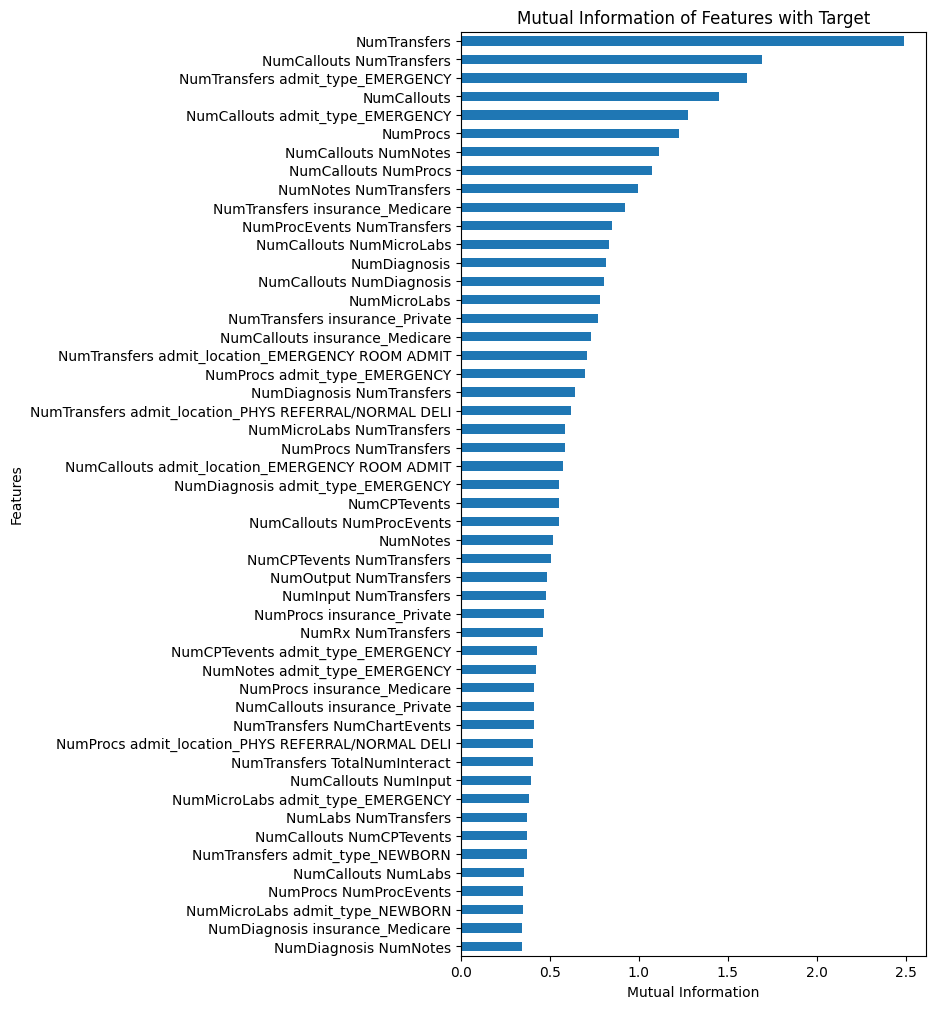

In [91]:
plt.figure(figsize=(6, 12))  # Adjust size as needed
mi_scores.head(50).plot(kind='barh')
plt.title('Mutual Information of Features with Target')
plt.xlabel('Mutual Information')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest MI scores at the top
plt.show()

### random forest

In [92]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # For Regression:
# model = RandomForestRegressor(n_estimators=200, random_state=42)

# model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [115]:
# y_pred = model.predict(X_test)

# # Calculate the performance metrics, e.g., R² score

# print(f"R² score on the test set: {r2_score(y_test, y_pred)}")

In [94]:
# importances = model.feature_importances_  # Feature importances from the model
# feature_names = X.columns  # Column names from your dataset

# # Create a DataFrame
# df_RF_importance = pd.DataFrame({
#     'Feature': feature_names,
#     'Importance': importances
# })


In [114]:
# feature_importances_df = df_RF_importance.sort_values(by='Importance', ascending=False)

# epsilon = 1e-12
# feature_importances_df['Adjusted Importance'] = np.clip(feature_importances_df['Importance'], epsilon, None)

# top_n = 50
# top_features = feature_importances_df.head(top_n)

# plt.figure(figsize=(8, 12))
# plt.title("Top Feature Importances")

# plt.barh(range(top_n), top_features['Adjusted Importance'][::-1], align="center")
# plt.yticks(range(top_n), top_features['Feature'][::-1])
# plt.xscale('log')  # Apply logarithmic scale
# plt.xlabel("Relative Importance (Log Scale)")
# plt.tight_layout()
# plt.show()

In [113]:
# corr_matrix = df_interactions.corr()

# target_corr = corr_matrix['LOSdays'].drop('LOSdays')

# target_corr_abs = target_corr.abs()
# plt.figure(figsize=(8, 20))
# target_corr_abs.sort_values().head(100).plot(kind='barh')
# plt.title('Correlation of Features with Target')
# plt.xlabel('Correlation Coefficient')
# plt.ylabel('Features')
# plt.show()

In [108]:
# ranking_df = pd.DataFrame({
#     'Feature': X.columns,  # Features from your dataset
#     'MI Score': mi_scores,
#     'Random Forest': importances,
#     'Correlation': target_corr_abs
# },index=X.columns)

# ranking_df['MI Rank'] = ranking_df['MI Score'].rank(ascending=False)
# ranking_df['RF Rank'] = ranking_df['Random Forest'].rank(ascending=False)
# ranking_df['Corr Rank'] = ranking_df['Correlation'].rank(ascending=False)

# ranking_df['Overall Rank Raw'] = ranking_df[['MI Rank', 'RF Rank', 'Corr Rank']].sum(axis=1)

# ranking_df['Overall Rank'] = ranking_df['Overall Rank Raw'].rank(ascending=True)
# ranking_df = ranking_df.drop(columns=['Overall Rank Raw'])

# ranking_df = ranking_df.sort_values(by='Overall Rank')

# ranking_df[['MI Rank', 'RF Rank', 'Corr Rank', 'Overall Rank']].head(10)

,MI Rank,RF Rank,Corr Rank,Overall Rank
NumTransfers,1.0,1.0,3.0,1.0
NumTransfers insurance_Private,16.0,10.0,6.0,2.0
NumCallouts NumTransfers,2.0,28.0,25.0,3.0
NumTransfers admit_location_PHYS REFERRAL/NORMAL DELI,21.0,4.0,34.0,4.0
NumCallouts NumProcs,8.0,33.0,37.0,5.5
NumCallouts,4.0,73.0,1.0,5.5
NumDiagnosis admit_type_EMERGENCY,25.0,30.0,24.0,7.5
NumCallouts admit_type_EMERGENCY,5.0,72.0,2.0,7.5
NumDiagnosis,13.0,52.0,15.0,9.0
NumCallouts NumNotes,7.0,20.0,70.0,10.0


In [111]:
# from sklearn.preprocessing import MinMaxScaler


# scaler = MinMaxScaler()

# scaled_df= pd.DataFrame()
# # Scale the column
# scaled_df['Feature'] = ranking_df['Feature']
# scaled_df['mi_scaled'] = scaler.fit_transform(ranking_df[['MI Score']]).flatten()
# scaled_df['rf_scaled'] = scaler.fit_transform(ranking_df[['Random Forest']]).flatten()
# scaled_df['corr_scaled'] = scaler.fit_transform(ranking_df[['Correlation']]).flatten()

# scaled_df['overall_scaled'] = scaled_df[['mi_scaled','rf_scaled','corr_scaled']].sum(axis=1)
# scaled_df = scaled_df.sort_values(by='mi_scaled',ascending=False).drop(columns=["Feature"])

In [116]:
# scaled_df.head(20)

In [129]:
df_interactions.shape

(2976, 407)

In [160]:
selected = mi_scores.head(5).index

from statsmodels.stats.outliers_influence import variance_inflation_factor



for_vif = df_interactions[selected]
vif_data = pd.DataFrame()
vif_data['Feature'] = for_vif.columns
vif_data['VIF'] = [variance_inflation_factor(for_vif.values, i) for i in range(for_vif.shape[1])]

# Show the VIF for each feature
print(vif_data)

                             Feature       VIF
0                       NumTransfers  5.290737
1           NumCallouts NumTransfers  3.868611
2  NumTransfers admit_type_EMERGENCY  2.539677
3                        NumCallouts  6.414891
4   NumCallouts admit_type_EMERGENCY  6.395863


In [136]:
selected = mi_scores.head(20).drop('NumProcs').index

for_vif = df_interactions[selected]
vif_data = pd.DataFrame()
vif_data['Feature'] = for_vif.columns
vif_data['VIF'] = [variance_inflation_factor(for_vif.values, i) for i in range(for_vif.shape[1])]

# Show the VIF for each feature
print(vif_data)

                                             Feature        VIF
0                                       NumTransfers  16.402711
1                           NumCallouts NumTransfers   6.263568
2                  NumTransfers admit_type_EMERGENCY  13.027405
3                                        NumCallouts   7.603672
4                   NumCallouts admit_type_EMERGENCY   7.119321
5                               NumCallouts NumNotes  59.180135
6                               NumCallouts NumProcs  12.758785
7                              NumNotes NumTransfers  76.475022
8                    NumTransfers insurance_Medicare   4.924507
9                         NumProcEvents NumTransfers   1.746845
10                          NumCallouts NumMicroLabs   3.469417
11                                      NumDiagnosis  13.642044
12                          NumCallouts NumDiagnosis   4.098685
13                                      NumMicroLabs   3.467921
14                    NumTransfers insur

In [137]:
selected = mi_scores.head(20).drop(['NumProcs','NumNotes NumTransfers']).index

for_vif = df_interactions[selected]
vif_data = pd.DataFrame()
vif_data['Feature'] = for_vif.columns
vif_data['VIF'] = [variance_inflation_factor(for_vif.values, i) for i in range(for_vif.shape[1])]

# Show the VIF for each feature
print(vif_data)

                                             Feature        VIF
0                                       NumTransfers  11.221627
1                           NumCallouts NumTransfers   5.592117
2                  NumTransfers admit_type_EMERGENCY  12.065462
3                                        NumCallouts   7.421157
4                   NumCallouts admit_type_EMERGENCY   7.105148
5                               NumCallouts NumNotes  18.333062
6                               NumCallouts NumProcs  12.377975
7                    NumTransfers insurance_Medicare   4.763939
8                         NumProcEvents NumTransfers   1.692129
9                           NumCallouts NumMicroLabs   3.469387
10                                      NumDiagnosis  11.545056
11                          NumCallouts NumDiagnosis   4.086209
12                                      NumMicroLabs   3.467398
13                    NumTransfers insurance_Private   2.458288
14                    NumCallouts insura

In [138]:
selected = mi_scores.head(20).drop(['NumProcs','NumNotes NumTransfers','NumDiagnosis NumTransfers']).index

for_vif = df_interactions[selected]
vif_data = pd.DataFrame()
vif_data['Feature'] = for_vif.columns
vif_data['VIF'] = [variance_inflation_factor(for_vif.values, i) for i in range(for_vif.shape[1])]

# Show the VIF for each feature
print(vif_data)

                                             Feature        VIF
0                                       NumTransfers  11.022771
1                           NumCallouts NumTransfers   5.394711
2                  NumTransfers admit_type_EMERGENCY   8.483506
3                                        NumCallouts   7.175986
4                   NumCallouts admit_type_EMERGENCY   7.010927
5                               NumCallouts NumNotes  11.754097
6                               NumCallouts NumProcs  12.272196
7                    NumTransfers insurance_Medicare   3.538462
8                         NumProcEvents NumTransfers   1.609136
9                           NumCallouts NumMicroLabs   3.467690
10                                      NumDiagnosis   8.529064
11                          NumCallouts NumDiagnosis   3.951471
12                                      NumMicroLabs   3.451297
13                    NumTransfers insurance_Private   2.142806
14                    NumCallouts insura

In [139]:
selected = mi_scores.head(20).drop(['NumProcs','NumNotes NumTransfers','NumDiagnosis NumTransfers','NumProcs admit_type_EMERGENCY']).index

for_vif = df_interactions[selected]
vif_data = pd.DataFrame()
vif_data['Feature'] = for_vif.columns
vif_data['VIF'] = [variance_inflation_factor(for_vif.values, i) for i in range(for_vif.shape[1])]

# Show the VIF for each feature
print(vif_data)

                                             Feature        VIF
0                                       NumTransfers  10.356661
1                           NumCallouts NumTransfers   5.057989
2                  NumTransfers admit_type_EMERGENCY   7.429545
3                                        NumCallouts   7.095510
4                   NumCallouts admit_type_EMERGENCY   7.008689
5                               NumCallouts NumNotes  10.309676
6                               NumCallouts NumProcs   6.308529
7                    NumTransfers insurance_Medicare   3.455172
8                         NumProcEvents NumTransfers   1.607732
9                           NumCallouts NumMicroLabs   3.433579
10                                      NumDiagnosis   8.527293
11                          NumCallouts NumDiagnosis   3.940406
12                                      NumMicroLabs   3.421002
13                    NumTransfers insurance_Private   2.092977
14                    NumCallouts insura

In [140]:
selected = mi_scores.head(20).drop(['NumProcs','NumNotes NumTransfers','NumDiagnosis NumTransfers','NumProcs admit_type_EMERGENCY','NumCallouts NumNotes']).index

for_vif = df_interactions[selected]
vif_data = pd.DataFrame()
vif_data['Feature'] = for_vif.columns
vif_data['VIF'] = [variance_inflation_factor(for_vif.values, i) for i in range(for_vif.shape[1])]

# Show the VIF for each feature
print(vif_data)

                                             Feature       VIF
0                                       NumTransfers  8.281880
1                           NumCallouts NumTransfers  4.891045
2                  NumTransfers admit_type_EMERGENCY  7.425289
3                                        NumCallouts  7.042030
4                   NumCallouts admit_type_EMERGENCY  6.995333
5                               NumCallouts NumProcs  3.302678
6                    NumTransfers insurance_Medicare  3.029805
7                         NumProcEvents NumTransfers  1.530391
8                           NumCallouts NumMicroLabs  3.430564
9                                       NumDiagnosis  8.515993
10                          NumCallouts NumDiagnosis  3.939284
11                                      NumMicroLabs  3.417241
12                    NumTransfers insurance_Private  1.812260
13                    NumCallouts insurance_Medicare  2.009145
14  NumTransfers admit_location_EMERGENCY ROOM ADMIT  3

In [143]:
features = vif_data['Feature'].to_list()

In [157]:
final_df = df_interactions[features]

final_df.head()

,NumTransfers,NumCallouts NumTransfers,NumTransfers admit_type_EMERGENCY,NumCallouts,NumCallouts admit_type_EMERGENCY,NumCallouts NumProcs,NumTransfers insurance_Medicare,NumProcEvents NumTransfers,NumCallouts NumMicroLabs,NumDiagnosis,NumCallouts NumDiagnosis,NumMicroLabs,NumTransfers insurance_Private,NumCallouts insurance_Medicare,NumTransfers admit_location_EMERGENCY ROOM ADMIT
0,0.124489,0.019240,0.124489,0.15455,0.15455,0.019611,0.000000,0.030163,-0.016898,-0.629062,-0.097221,-0.109338,0.124489,0.00000,0.124489
1,-0.905511,0.023045,-0.905511,-0.02545,-0.02545,-0.004502,-0.000000,-3.035536,-0.013505,-1.889062,0.048077,0.530662,-0.000000,-0.00000,-0.000000
2,-0.615511,-0.002800,-0.615511,0.00455,0.00455,-0.002562,-0.615511,0.460223,-0.005229,-1.169062,-0.005319,-1.149338,-0.000000,0.00455,-0.000000
3,-0.445511,0.042524,-0.445511,-0.09545,-0.09545,0.061385,-0.445511,0.333112,0.107796,-1.069062,0.102042,-1.129338,-0.000000,-0.09545,-0.445511
4,1.704489,-0.162694,1.704489,-0.09545,-0.09545,0.082384,0.000000,-1.274461,-0.812345,-1.449062,0.138313,8.510662,1.704489,-0.00000,0.000000


In [158]:
my_final_df = pd.concat([df_interactions['LOSdays'],final_df],axis=1)
my_final_df.to_csv("data-p2/more_selected_interactions_mimic3d.csv",index=False)

In [159]:
my_final_df.shape

(2976, 16)

In [ ]:
df_interactions

In [47]:
df_interactions.to_csv("data-p2/full_interactions_mimic3d.csv",index=False)

Conclusion - going to try NumTransfers NumCallouts